In [ ]:
%run C:\Users\Omar\Intern_Final_Project\notebooks\Data_Cleaning\Features_Engineering.ipynb

### *cross validation*

*We will keep the last 16 rows of the dataset and do a Rolling Moving Origin of step size of 4*


*lets explain this visually*

In [6]:
from sklearn.model_selection import TimeSeriesSplit

In [7]:
test_data_red=df_red[-16:]
#####
X = test_data_red.drop("price",axis=1)
y = test_data_red["price"]
date=test_data_red.reset_index()["week_end_dt"]
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)
for i, (train_index, test_index) in enumerate(tscv.split(X)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

Fold 0:
  Train: index=[0 1 2 3]
  Test:  index=[4 5 6 7]
Fold 1:
  Train: index=[0 1 2 3 4 5 6 7]
  Test:  index=[ 8  9 10 11]
Fold 2:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11]
  Test:  index=[12 13 14 15]


The above code out come expresess how the cross validation works ,
1st fold : we consider the 4 intial points as train data and the next 4 points as test data
2ns fold : the test points from the prevuoys fold we be appened to the new train points asnd new points ahead are test points
3rd fold : works as metioned above

The below chart is ease the process:


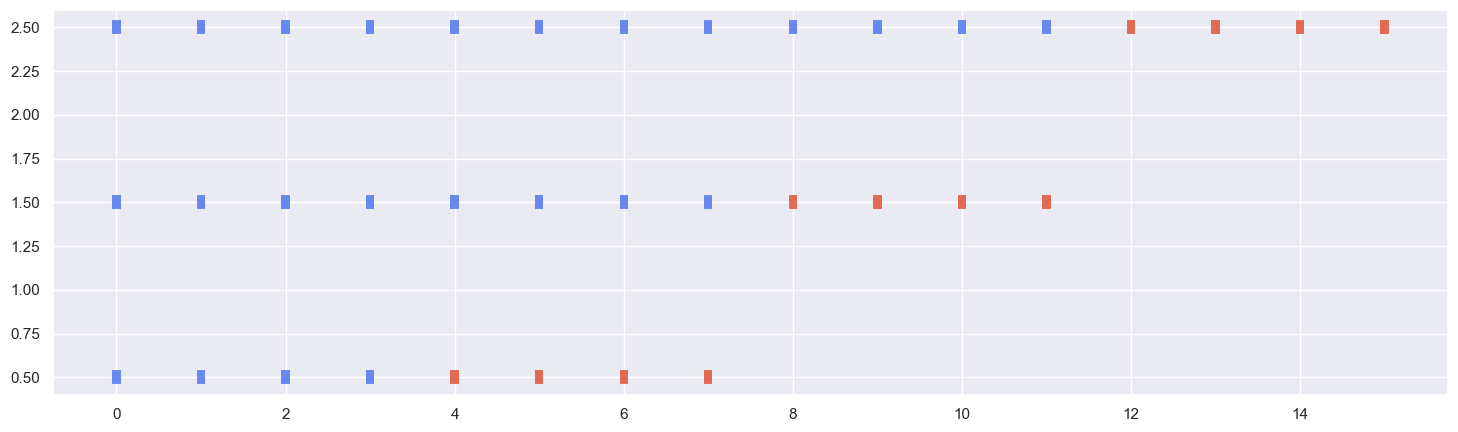

In [8]:
cmap_data = plt.cm.Paired
cmap_cv = plt.cm.coolwarm

def plot_cv_indices(cv, n_splits, X, y):
    fig, ax = plt.subplots(1, 1, figsize = (18, 5))
    for ii, (tr, tt) in enumerate(cv.split(X=X, y=y)):
        indices = np.array([np.nan] * len(X))
        indices[tt] = 1
        indices[tr] = 0

        ax.scatter(range(len(indices)), [ii + .5] * len(indices),
                   c=indices, marker='_', lw=10, cmap=cmap_cv,
                   vmin=-.2, vmax=1.2)
        
plot_cv_indices(cv=tscv,n_splits=3,X=X,y=y)

---
importing needed libraries

In [9]:
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from xgboost import plot_tree,plot_importance,XGBRegressor,XGBRFRegressor
from sklearn.linear_model import LinearRegression,LogisticRegression,SGDRegressor
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
from lightgbm.sklearn import LGBMRegressor
import warnings                                  
warnings.filterwarnings('ignore')

In [10]:
tscv = TimeSeriesSplit(n_splits=3,max_train_size=16,test_size=4,gap=0)

In [ ]:
mape_scores = []
y_pred_red_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


test_data_red=df_red  
time_series_data_red = test_data_red.values

for model in models:
              for train_index, test_index in tscv.split(time_series_data_red):
                                  X_train, y_train = time_series_data_red[train_index, 1:], time_series_data_red[train_index, 0]
                                  X_test, y_test = time_series_data_red[test_index, 1:], time_series_data_red[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred_red = model.predict(X_test)
                                  y_pred_red_results.append(y_pred_red)
                                  mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_red))
                                  mape_scores.append(mape)       


outcome_red=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_red_results[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_red_results[24:27]).stack().reset_index(drop=True))],axis=1)                                

outcome__red_mape=pd.concat([pd.DataFrame(pd.DataFrame(mape_scores[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[24:27]).stack().reset_index(drop=True)),],axis=1)

In [24]:

new_date_index=pd.date_range(start="2023-07-16",end="2023-10-01",freq="W")
new_date_index=pd.DataFrame({"date":new_date_index})
outcome_red.columns=models_names
outcome_red_all=pd.concat([outcome_red,new_date_index],axis=1).set_index("date")
outcome__red_mape.columns=models_names


In [ ]:
mape_scores = []
y_pred_green_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


test_data_green=df_green  
time_series_data_green = test_data_green.values

for model in models:
              for train_index, test_index in tscv.split(time_series_data_green):
                                  X_train, y_train = time_series_data_green[train_index, 1:], time_series_data_green[train_index, 0]
                                  X_test, y_test = time_series_data_green[test_index, 1:], time_series_data_green[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred_green = model.predict(X_test)
                                  y_pred_green_results.append(y_pred_green)
                                  mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_green))
                                  mape_scores.append(mape)       


outcome_green=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_green_results[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_green_results[24:27]).stack().reset_index(drop=True))],axis=1)                                

outcome__green_mape=pd.concat([pd.DataFrame(pd.DataFrame(mape_scores[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[24:27]).stack().reset_index(drop=True)),],axis=1)

In [124]:
outcome_green.columns=models_names
outcome_green_all=pd.concat([outcome_green,new_date_index],axis=1).set_index("date")
outcome__green_mape.columns=models_names

In [ ]:
mape_scores = []
y_pred_yellow_results=[]

models_names=["DecisionTreeRegressor","RandomForestRegressor","SVR()","LinearRegression","XGBRegressor_boo",
                  "XGBRFRegressor_boo","AdaBoostRegressor_boo","LGBMRegressor_boo","CatBoostRegressor_boo"]
              
models=[DecisionTreeRegressor(random_state=0),RandomForestRegressor(random_state=0),SVR(),LinearRegression(),XGBRegressor(random_state=0),
        XGBRFRegressor(random_state=0),AdaBoostRegressor(random_state=0),LGBMRegressor(force_row_wise=True),CatBoostRegressor()]


test_data_yellow=df_yellow
time_series_data_yellow = test_data_yellow.values

for model in models:
              for train_index, test_index in tscv.split(time_series_data_yellow):
                                  X_train, y_train = time_series_data_yellow[train_index, 1:], time_series_data_yellow[train_index, 0]
                                  X_test, y_test = time_series_data_yellow[test_index, 1:], time_series_data_yellow[test_index, 0]

                                  model.fit(X_train, y_train)
                                  y_pred_yellow = model.predict(X_test)
                                  y_pred_yellow_results.append(y_pred_yellow)
                                  mape = np.mean(mean_absolute_percentage_error(y_test, y_pred_yellow))
                                  mape_scores.append(mape)       


outcome_yelow=pd.concat([pd.DataFrame(pd.DataFrame(y_pred_yellow_results[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(y_pred_yellow_results[24:27]).stack().reset_index(drop=True))],axis=1)                                

outcome__yellow_mape=pd.concat([pd.DataFrame(pd.DataFrame(mape_scores[0:3]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[3:6]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[6:9]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[9:12]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[12:15]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[15:18]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[18:21]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[21:24]).stack().reset_index(drop=True)),
           pd.DataFrame(pd.DataFrame(mape_scores[24:27]).stack().reset_index(drop=True)),],axis=1)

In [32]:
outcome_yelow.columns=models_names
outcome_yelow_all=pd.concat([outcome_yelow,new_date_index],axis=1).set_index("date")
outcome__yellow_mape.columns=models_names

In [37]:
outcome__red_mape

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,0.101660,0.070773,0.039770,0.162683,0.085812,0.052707,0.092535,0.037060,0.046031
1,0.074028,0.099128,0.101483,0.023267,0.056023,0.078278,0.077928,0.102334,0.081130
2,0.090173,0.056584,0.091439,0.039803,0.041372,0.038814,0.051380,0.125801,0.065991


In [125]:
pd.DataFrame(outcome__red_mape.mean(),columns=['score']).reset_index().sort_values(by="score").T

,5,4,8,6,3,1,2,7,0
index,XGBRFRegressor_boo,XGBRegressor_boo,CatBoostRegressor_boo,AdaBoostRegressor_boo,LinearRegression,RandomForestRegressor,SVR(),LGBMRegressor_boo,DecisionTreeRegressor
score,0.0566,0.061069,0.064384,0.073948,0.075251,0.075495,0.077564,0.088398,0.08862


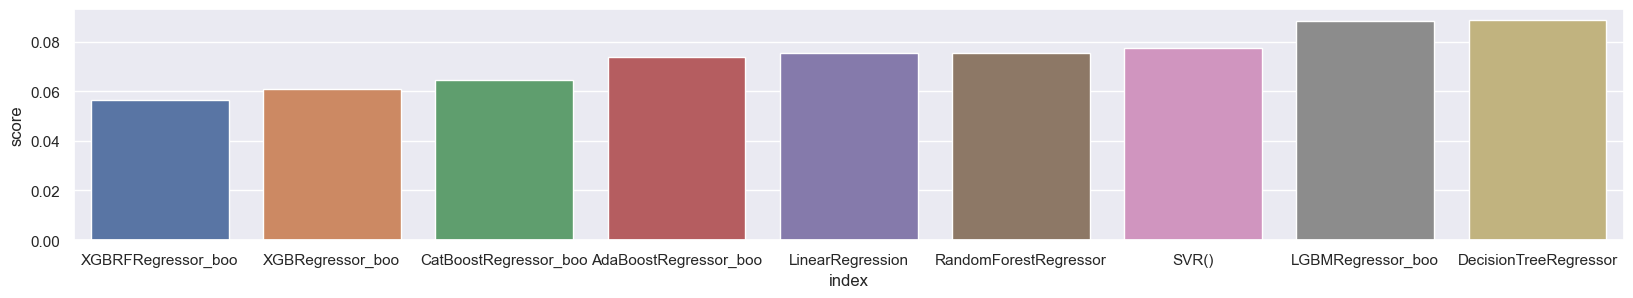

In [50]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(outcome__red_mape.mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

In [51]:
outcome__green_mape

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,0.075194,0.055353,0.043939,0.241405,0.064524,0.055279,0.075194,0.044919,0.031781
1,0.036107,0.070381,0.076303,0.093476,0.057451,0.068309,0.060876,0.066799,0.059588
2,0.019783,0.016044,0.041421,0.108615,0.025340,0.019488,0.011218,0.074411,0.018278


In [126]:
pd.DataFrame(outcome__green_mape.mean(),columns=['score']).reset_index().sort_values(by="score").T

,8,0,1,5,6,4,2,7,3
index,CatBoostRegressor_boo,DecisionTreeRegressor,RandomForestRegressor,XGBRFRegressor_boo,AdaBoostRegressor_boo,XGBRegressor_boo,SVR(),LGBMRegressor_boo,LinearRegression
score,0.036549,0.043694,0.047259,0.047692,0.049096,0.049105,0.053887,0.062043,0.147832


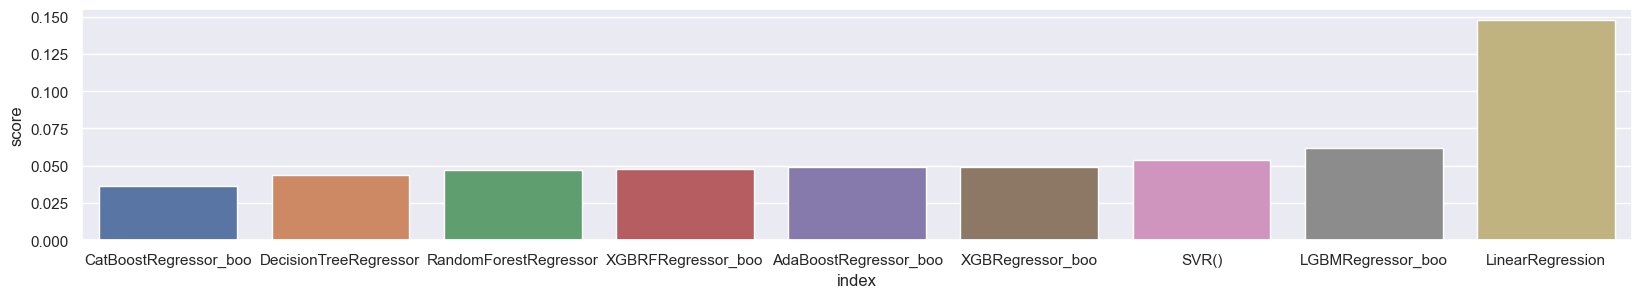

In [54]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(pd.DataFrame(outcome__green_mape.mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

In [55]:
outcome__yellow_mape

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
0,0.040295,0.076628,0.252041,0.113661,0.050379,0.096163,0.053092,0.239946,0.140609
1,0.166530,0.130935,0.126978,0.347467,0.175851,0.156423,0.166530,0.116027,0.123426
2,0.118649,0.098543,0.189880,0.195092,0.054781,0.078171,0.061649,0.133924,0.103521


In [127]:
pd.DataFrame(outcome__yellow_mape.mean(),columns=['score']).reset_index().sort_values(by="score").T

,4,6,1,0,5,8,7,2,3
index,XGBRegressor_boo,AdaBoostRegressor_boo,RandomForestRegressor,DecisionTreeRegressor,XGBRFRegressor_boo,CatBoostRegressor_boo,LGBMRegressor_boo,SVR(),LinearRegression
score,0.09367,0.093757,0.102035,0.108491,0.110252,0.122519,0.163299,0.189633,0.21874


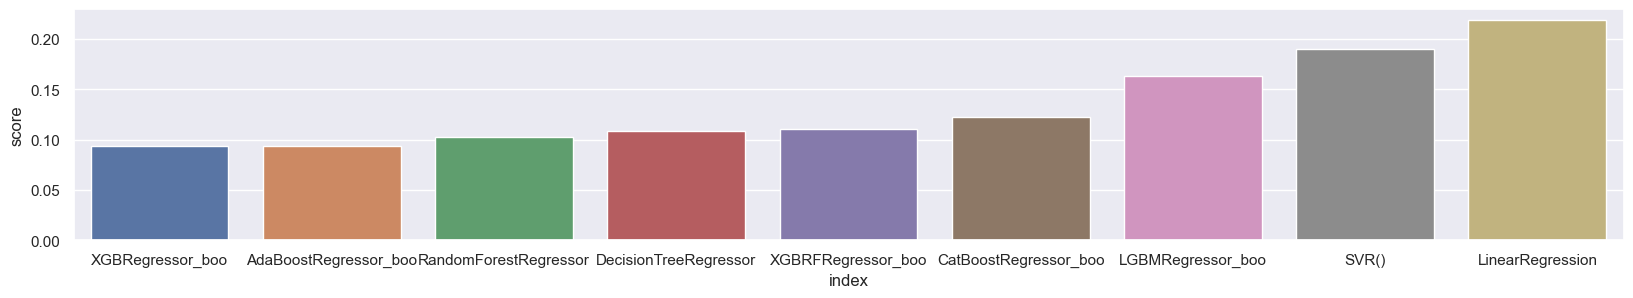

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (20,3))
sns.barplot(data=pd.DataFrame(outcome__yellow_mape.mean(),columns=['score']).reset_index().sort_values(by="score"),x="index",y="score");

In [77]:
outcome_red_all

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-07-16,9.133865,8.690617,7.776439,9.249168,8.753510,8.297154,8.827480,7.868116,8.644695
2023-07-23,8.827480,8.641781,7.801422,9.825235,8.750635,8.579571,8.827480,7.868116,8.507625
2023-07-30,8.827480,8.635291,7.824496,9.478783,8.835210,8.591850,8.827480,7.868116,8.373076
2023-08-06,8.827480,8.640989,7.848699,9.047511,8.750635,8.367471,8.827480,7.868116,8.300095
2023-08-13,7.742870,7.910325,7.939172,7.372527,7.517401,7.673603,7.783408,7.966054,7.790764
2023-08-20,7.742870,7.907445,7.946212,7.042867,7.518683,7.703681,7.763342,7.966054,7.804392
2023-08-27,7.742870,7.934342,7.968775,7.074313,7.478860,7.777675,7.797463,7.966054,7.810019
2023-09-03,7.742870,8.014982,7.982915,7.015632,7.518679,7.802621,7.813061,7.966054,7.843598
2023-09-10,7.209757,7.239061,7.665649,6.966725,6.982857,7.067555,7.209757,7.901178,7.349349


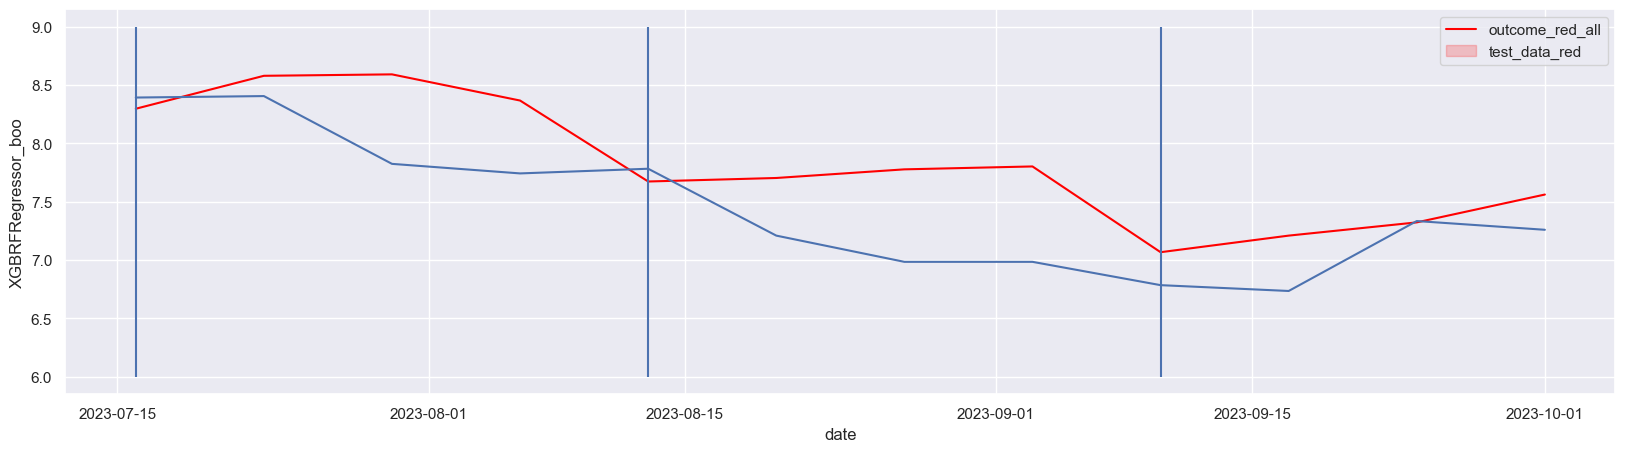

In [113]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(outcome_red_all['XGBRFRegressor_boo'],color="red");
sns.lineplot(test_data_red[-12:]["price"]);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_red_all","test_data_red"])

In [95]:
outcome_green_all

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-07-16,7.961280,7.866575,7.115371,8.285854,7.961137,7.701177,7.961280,7.123615,7.772835
2023-07-23,7.961280,7.808593,7.140414,8.966301,7.857399,7.870447,7.961280,7.123615,7.645405
2023-07-30,7.961280,7.799061,7.168484,9.620984,7.857399,7.773847,7.961280,7.123615,7.537312
2023-08-06,7.961280,7.786750,7.197057,9.807017,7.857399,7.871897,7.961280,7.123615,7.453565
2023-08-13,6.749605,7.293158,7.308527,7.134227,7.117745,7.240502,7.193434,7.253109,7.223768
2023-08-20,6.749605,7.271412,7.311642,7.316439,7.118186,7.267720,7.193434,7.253109,7.183920
2023-08-27,6.749605,7.270581,7.324328,7.869666,7.181943,7.274973,7.193434,7.253109,7.192904
2023-09-03,6.749605,7.275876,7.325252,7.201770,7.118112,7.268367,7.193434,7.253109,7.196729
2023-09-10,6.560342,6.671198,7.038055,7.118210,6.613306,6.602183,6.560342,7.252487,6.711012


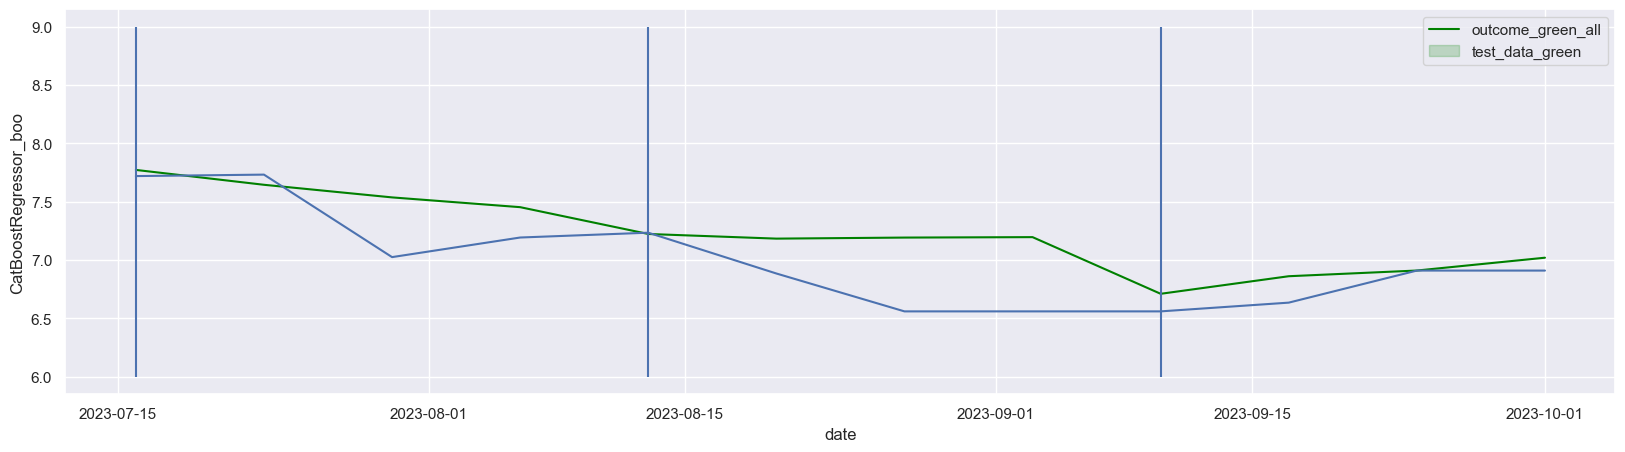

In [107]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 6
y_max = 9
sns.lineplot(outcome_green_all['CatBoostRegressor_boo'],legend=True,color="green");
sns.lineplot(test_data_green[-12:]["price"],legend=True);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_green_all","test_data_green"])

In [117]:
outcome_yelow_all

,DecisionTreeRegressor,RandomForestRegressor,SVR(),LinearRegression,XGBRegressor_boo,XGBRFRegressor_boo,AdaBoostRegressor_boo,LGBMRegressor_boo,CatBoostRegressor_boo
date,,,,,,,,,
2023-07-16,10.753280,10.400519,8.336244,11.162956,10.660778,9.684439,10.753280,8.516236,10.023769
2023-07-23,10.753280,10.327073,8.368286,12.078565,10.661068,10.427487,10.560280,8.516236,9.696390
2023-07-30,10.753280,10.324516,8.393637,12.788120,10.661258,10.451442,10.560280,8.516236,9.453245
2023-08-06,10.753280,10.330893,8.429629,14.042112,10.571139,9.927623,10.560280,8.516236,9.311140
2023-08-13,12.138784,11.573263,9.215914,12.983228,11.409286,11.098691,12.138784,9.338898,11.625233
2023-08-20,12.138784,11.560537,9.212661,14.005476,12.135858,11.757110,12.138784,9.338898,11.423490
2023-08-27,12.138784,11.508555,9.230974,14.508899,12.137550,11.751242,12.138784,9.338898,11.427784
2023-09-03,12.138784,11.477013,9.229548,15.090285,11.947100,11.678661,12.138784,9.338898,11.331702
2023-09-10,11.480909,9.873171,10.664574,8.969494,9.871533,10.055518,9.432754,10.074917,9.736846


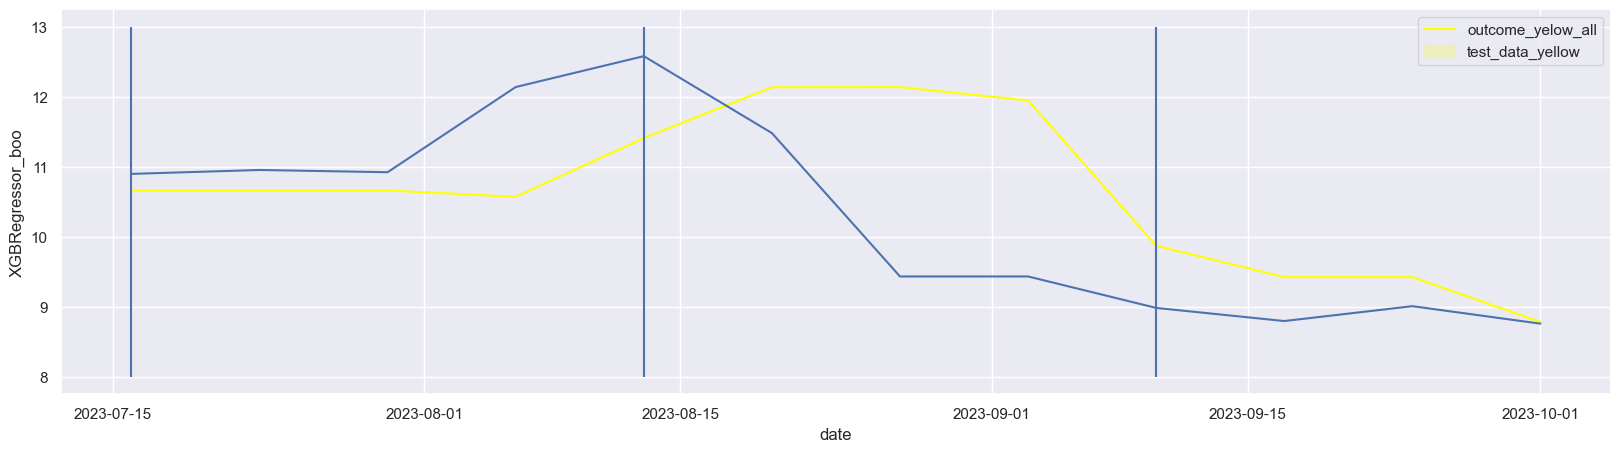

In [119]:
fig, ax = plt.subplots(figsize = (20,5));
y_min = 8
y_max = 13
sns.lineplot(outcome_yelow_all['XGBRegressor_boo'],legend=True,color="yellow");
sns.lineplot(test_data_yellow[-12:]["price"],legend=True);
ax.vlines(x=["2023-07-16","2023-08-13","2023-09-10"],ymax=y_max,ymin=y_min)
plt.legend(["outcome_yelow_all","test_data_yellow"])

---

## *Classical statistical model -sarimax*

*lets look to see if any color has seasonality in the data or no*

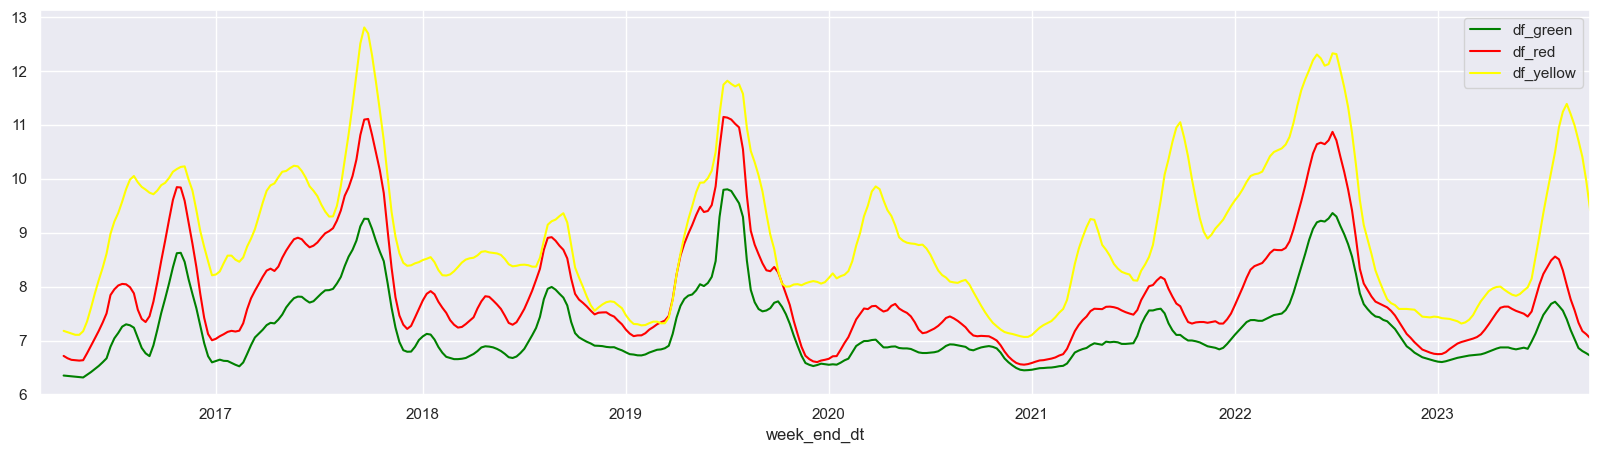

In [120]:
df_green["price"].rolling(window=7).mean().plot(figsize=(20,5),color="green");
df_red["price"].rolling(window=7).mean().plot(figsize=(20,5),color="red");
df_yellow["price"].rolling(window=7).mean().plot(figsize=(20,5),color="yellow");
plt.legend(["df_green","df_red","df_yellow"]);

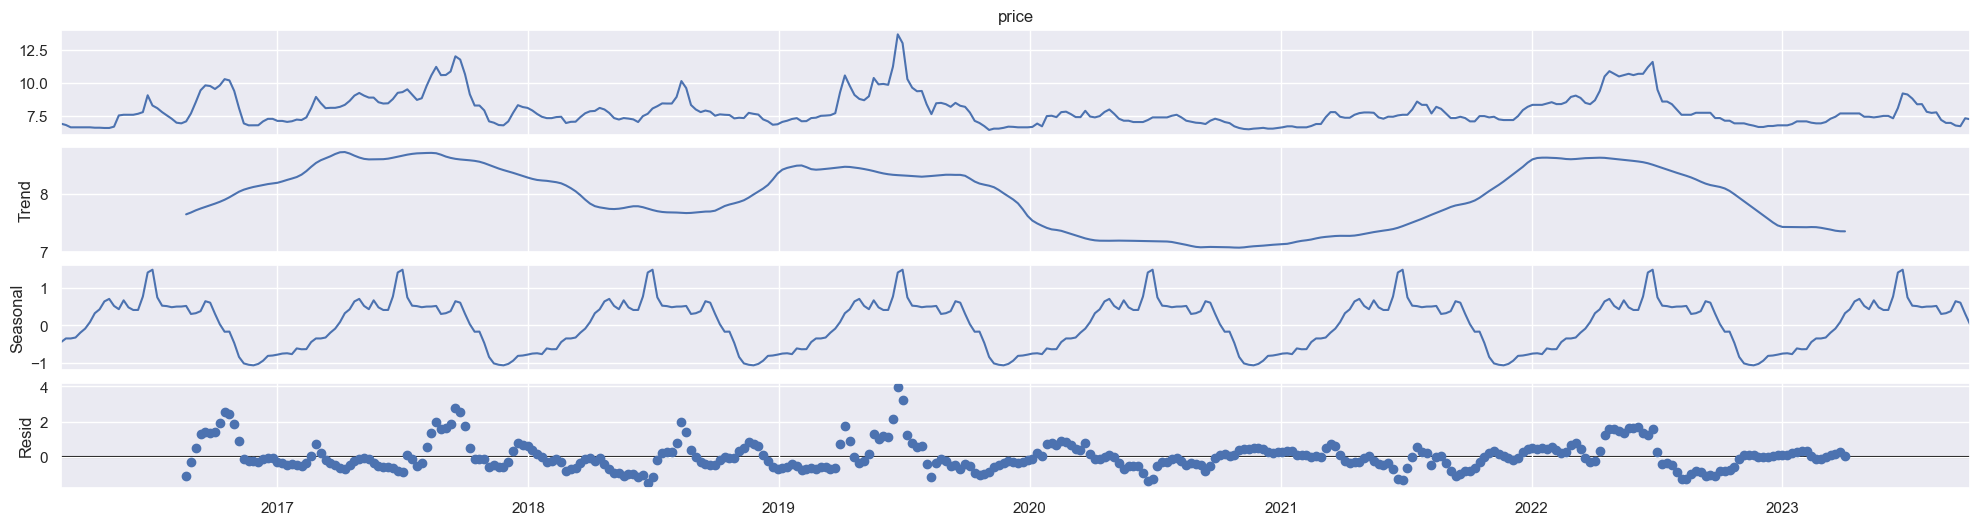

In [121]:
from statsmodels.tsa.api import seasonal_decompose
seasonal_decompose(df_red['price']).plot().set_size_inches((20, 5));

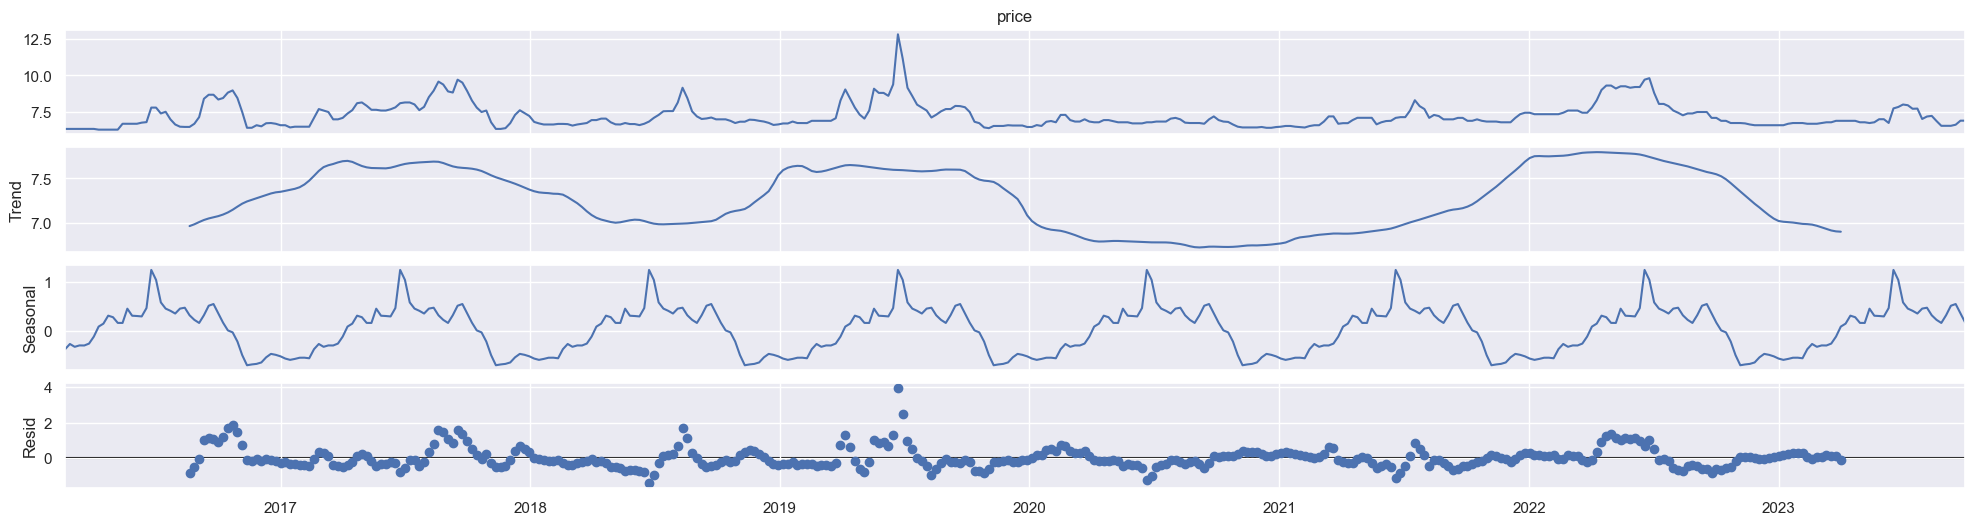

In [122]:
seasonal_decompose(df_green['price']).plot().set_size_inches((20, 5));

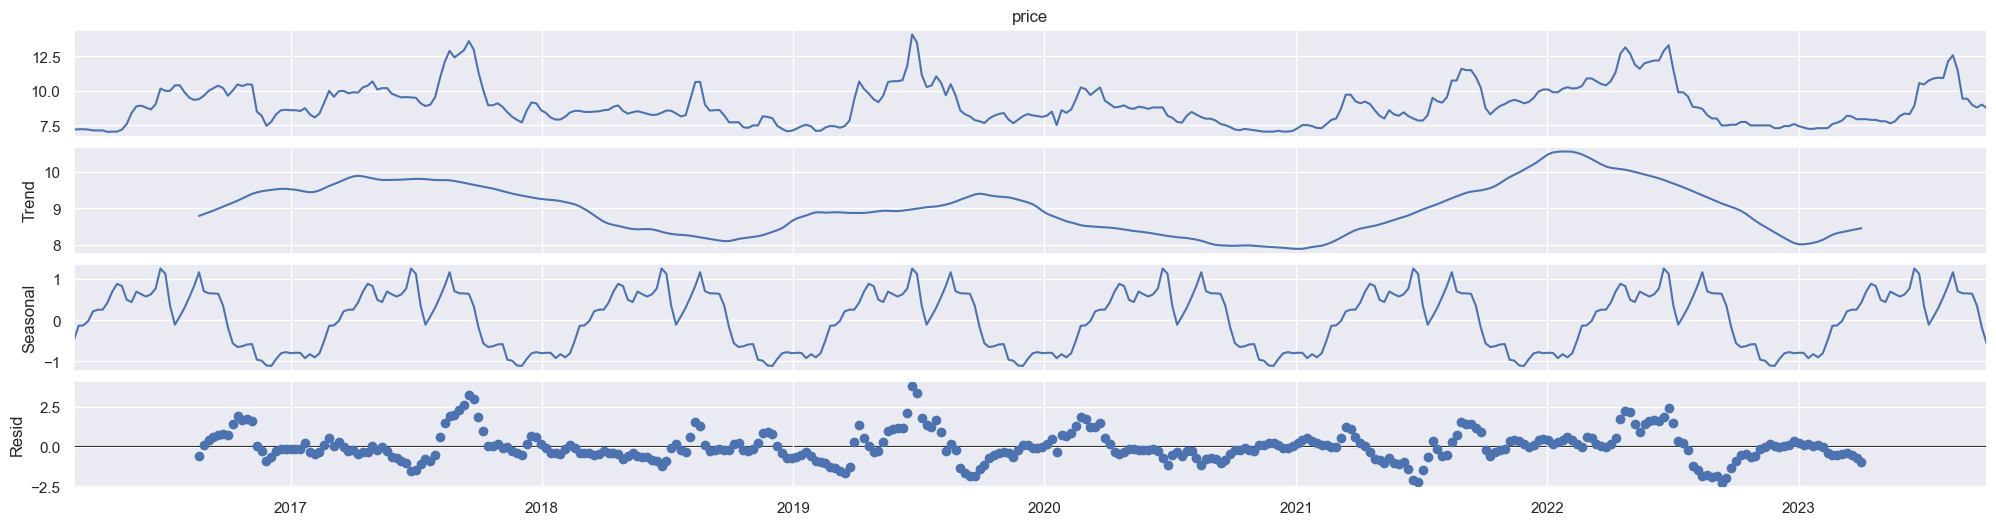

In [123]:
seasonal_decompose(df_yellow['price']).plot().set_size_inches((20, 5));